In [1]:
"""
This file is used to load and run a trained model. for evaluation purposes.
"""
import os
import sys
# adding project directory to path, this is a bit hacky and may not work for all
sys.path.insert(0, os.path.abspath(os.path.dirname(os.path.abspath(''))))
import torch
from config import rootdir
from kbgen.data.datasets import GSM
from kbgen.utils import get_key_padding_mask, Accuracy
from kbgen.utils.log import RunTracker
from matplotlib import pyplot as plt
import tqdm 
from kbgen.model.embeddings import DICE

In [2]:
# DATA -----------------------------------------------------
device = "cuda:0" if torch.cuda.is_available() else "cpu"
dataset = GSM(os.path.join(rootdir, "data/gsm"), device=device)
torch.set_default_device(device)
# Load Wandb Run -----------------------------------------------------
# You need to pick a run that is saved locally
logdir = os.path.join(rootdir, "models/07-04-13-01-15long-clean_L1td3_te3_d128")
run = RunTracker.from_logdir(logdir)
assert run.config.fields == dataset.fields, "Fields do not match. Check that the dataset is the same as the one used for training."
model = run.load_latest_model().to(device)
model.eval()
print(run.config)
# Set up metrics -----------------------------------------------------

field_prototypes_dict = {"phone.launch.day" : torch.arange(1, 32), 
                        "phone.launch.month" : torch.arange(1, 13),
                        "phone.launch.year" : torch.arange(1994, 2021),
                        "phone.height" : torch.linspace(0, 452, 1000),
                        "phone.width" : torch.linspace(0, 284, 1000),
                        "phone.depth" : torch.linspace(0, 75, 1000),
                        "phone.weight" : torch.linspace(0, 2019, 5000),
                        "phone.display_size" : torch.linspace(2, 50, 1000),
                        "phone.battery" : torch.linspace(0, 15, 400),
}

accuracy = Accuracy(dataset.categorical_pad_token, dataset.numerical_pad_token, field_prototypes_dict, rtol=1e-3)
prototypes_emb_dict = {field : model.numerical_embed(prototypes) for field, prototypes in field_prototypes_dict.items()}

KeyError: 'tie_numerical_embeddings'

In [8]:
scale = 100
dice = DICE(128, -scale, scale)
embs = dice(torch.tensor([0,  1 * scale]))
print(embs.norm(dim=-1))
print("cdist", *torch.cdist(embs, embs, p=2).tolist(), sep="\n")
print("cos", * (1 - (embs @ embs.T)/ (embs.norm(dim=-1) * embs.norm(dim=-1, keepdim=True))).tolist(), sep="\n")

tensor([1.0000, 1.0000], device='cuda:0', dtype=torch.float64)
cdist
[0.0, 1.414213531464473]
[1.414213531464473, 0.0]
cos
[-2.220446049250313e-16, 0.9999999562886136]
[0.9999999562886136, -2.220446049250313e-16]


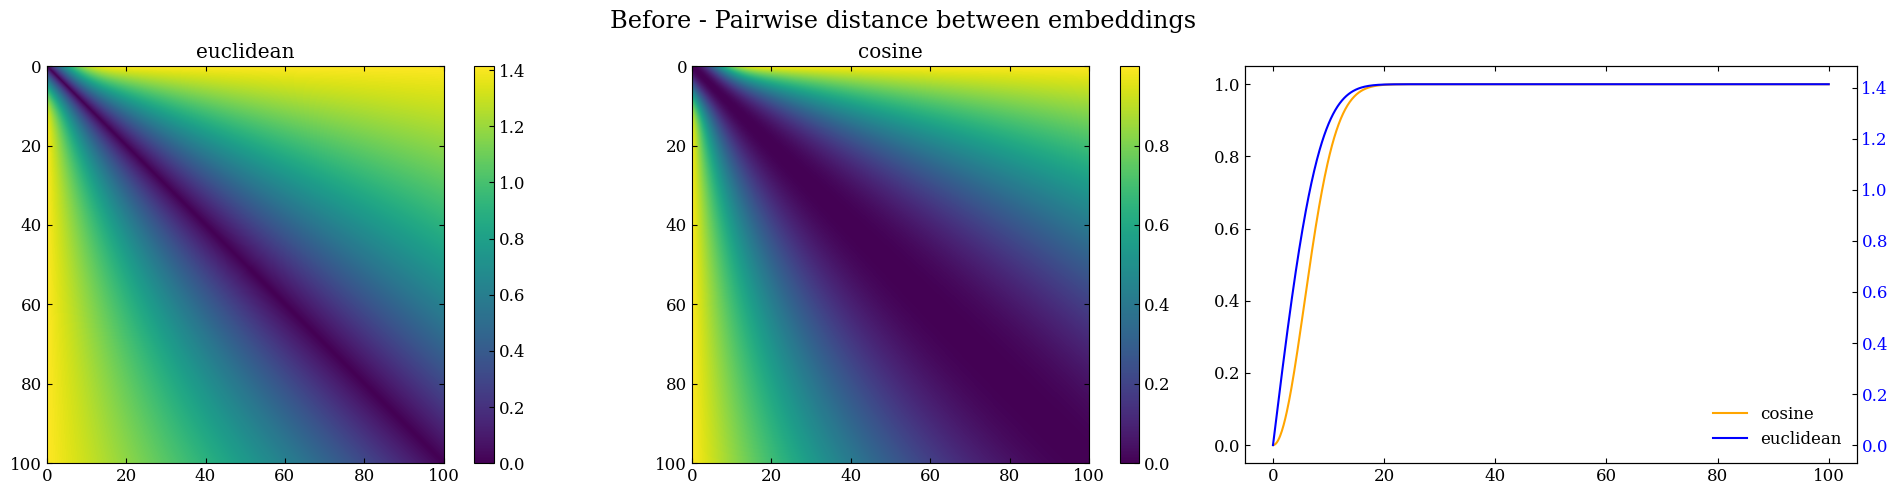

In [9]:
def plot_distances(embed_func, title="Before"):
    x = torch.linspace(0., 1 * scale, 1000).to(device)
    embs = embed_func(x)
    # pairwise distance between embs
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle(f"{title} - Pairwise distance between embeddings")
    d_l2 = torch.cdist(embs, embs)
    plt.colorbar(axes[0].imshow(d_l2.cpu().detach().numpy(), extent=[0, scale, scale, 0]))
    axes[0].set_title("euclidean")
    d_cos = 1 -  (embs @ embs.T) #/ (embs.norm(dim=-1) * embs.norm(dim=-1, keepdim=True))
    plt.colorbar(axes[1].imshow(d_cos.cpu().detach().numpy(), extent=[0, scale, scale, 0]))
    axes[1].set_title("cosine")
    ax2 = axes[2]
    ax2.plot(x.cpu().detach().numpy(), d_cos[0].cpu().detach().numpy(), label="cosine", color="orange")
    # d_true= 1 - torch.cos((x - embed_func.min_bound)/(embed_func.max_bound - embed_func.min_bound) * np.pi)
    # ax2.plot(x.cpu().detach(), d_true.cpu().detach(), label="cosine", color="red")
    (ax2_ :=ax2.twinx()).tick_params(axis='y', labelcolor="blue")
    ax2_.plot(x.cpu().detach().numpy(), d_l2[0].cpu().detach().numpy(), label="euclidean", color="blue")
    plt.legend(ax2.get_lines() + ax2_.get_lines(), [l.get_label() for l in ax2.get_lines() + ax2_.get_lines()])
    plt.tight_layout()
# plot_distances(model.numerical_embed)
plot_distances(dice)

In [48]:
def reg_loss(samples=2, scale=10):
    x = (torch.exp(torch.rand(samples)) - 1) / (torch.exp(torch.tensor(1.)) - 1) * scale
    # print(x)
    x_embed = model.numerical_embed(x)
    # print(x_embed)
    norms = x_embed.norm(dim=-1)
    # print(norms)
    d_cos = 1 - (x_embed @ x_embed.T) / (norms * norms.unsqueeze(-1))
    # print(d_cos)
    d = 2 * (x - x.unsqueeze(-1)).abs() / (x.abs() + x.unsqueeze(-1).abs())
    # print(d)
    # print(d - d_cos)
    return (d - d_cos).pow(2).mean()

optim = torch.optim.Adam(model.parameters(), lr=1e-3)
for _ in (pbar:=tqdm.trange(10000)):
    optim.zero_grad()
    loss = reg_loss(samples=1000, scale=scale)
    loss.backward()
    optim.step()
    pbar.set_description(f"loss: {loss.item():.4f}")

  0%|          | 0/10000 [00:00<?, ?it/s]

loss: 0.1187:   9%|▉         | 898/10000 [00:02<00:29, 305.23it/s]


KeyboardInterrupt: 

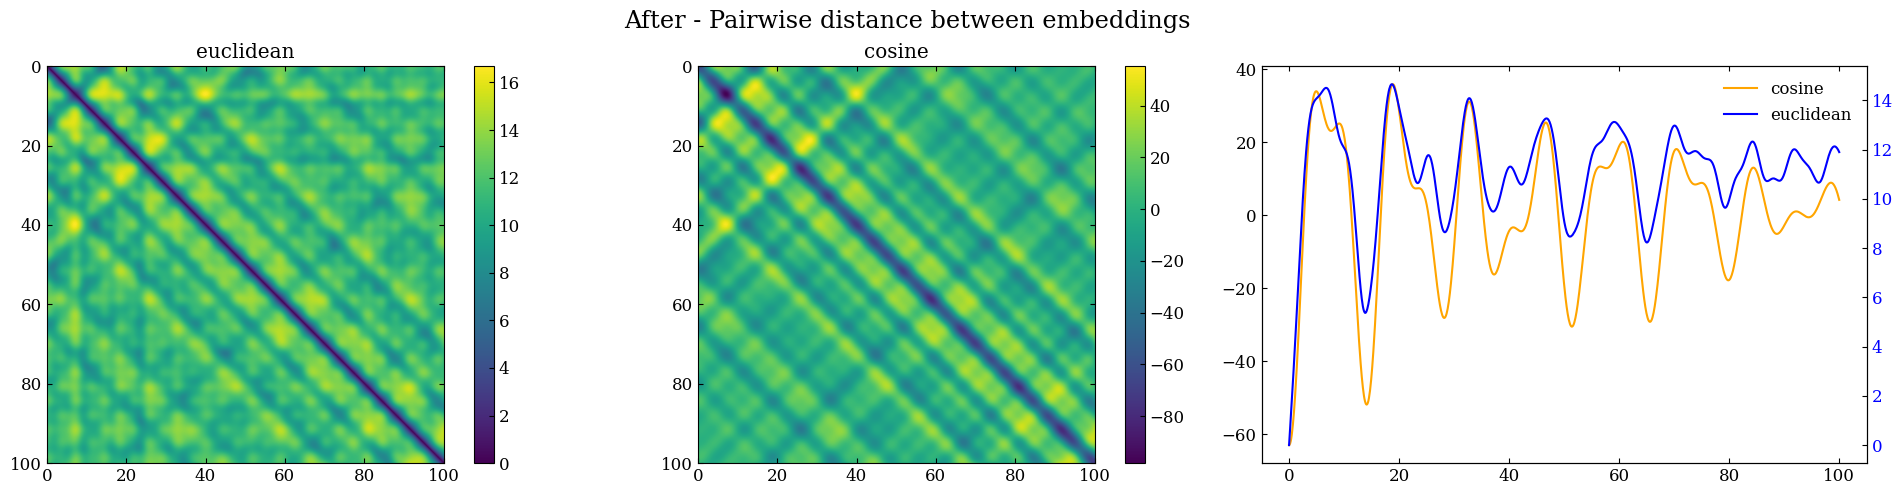

In [50]:
scale = 100
plot_distances(model.numerical_embed, "After")

In [2]:
from kbgen.model.embeddings import BinnedEmbedding

In [7]:
be = BinnedEmbedding(2, extent=(0, 100))
x = torch.linspace(0, 20, 10)
be(x)


tensor([[5.0000e-01, 0.0000e+00],
        [8.9891e-01, 0.0000e+00],
        [9.8751e-01, 0.0000e+00],
        [9.9858e-01, 0.0000e+00],
        [9.9984e-01, 3.1630e-39],
        [9.9998e-01, 2.7486e-38],
        [1.0000e+00, 2.3886e-37],
        [1.0000e+00, 2.0757e-36],
        [1.0000e+00, 1.8038e-35],
        [1.0000e+00, 1.5675e-34]], grad_fn=<SigmoidBackward0>)

In [ ]:
# single feature auto encode using different embeddings
# N features
# real data with masking